## ARIMA Models

ARIMA stands for Autoregressive Integrated Moving Average. Compared with the above model it uses a linear combination of past time steps, and moving averages to predict t.


## Contents 
1. ARIMA parameters analysis
2. ARIMA multi-step taining and evaluation


#### ARIMA Models Evaluated
1. Multi-setp output ARIMA






ARIMA takes only a stationary time series. As explored in the ***DATA ANALYSIS*** notebook the load data can be made stationary by ***ANALYSIS RESULTS***



We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in the model and can be estimated from Autocorrelation plots
- d: the number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: the side of the moving average window. The order of moving average.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
sns.set_style('dark')

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from model_persistence import get_persistence_dataset, train_test_split, walk_forward_evaluation, calculate_errors, plot_error

In [31]:
#load the dataset and crete the train and test sets.
data = get_persistence_dataset()
train, test = train_test_split(data)
train.head(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


### ARIMA Parameter Analysis


We will use the ARIMA model from statsmodels.api. The ARIMA takes three arguments p, d, q and represent the model's lags, differncing, and moving window size. Arriving at their inital values is done via the box-jenkins method described below:
- p: The number of lag observations in the model and can be estimated from an Autocorrelation plot as the number of lag points that show deviation outside the confidence band.
- d: The number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: The side of the moving average window. The order of moving average.

##### Startionay and differncing of the dataset

As described in the stationary test in the Data Analysis workbook, set of daily mean data was stationary. Here we test if the hourly data is stationary using the adfuller test over a period of 1 week of lags (24 * 7).

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

In [55]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

adful_t = sm.tsa.adfuller(train_flat, maxlag=24*7)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -7.804579e+00
p-value           7.339533e-12
#Lags             1.680000e+02
Observations      2.613500e+04
dtype: float64


The p-value of the test is significantly smaller than the threshold of 0.05 and therefore we ***reject the null*** and assume a stationary dataset.

Therefore the default model paramter for d (the differncing value) is 0. We will also invesitgate a differencing paramter of 24 and 168 corresponding with the previous day, and the previous week.



##### Autocorrelation and partial autocorrelation

Descrption of the plots:

ACF - Describes the direct and indirect relationships between laging (shifted) autoregressive features. I.e. the relationships between t, t-1, t-2, t-3 etc. taking into account the interrelatinships between features, in this case t-1 and t-2, t-2 and t-3 etc.

PACF - Describes only the direct relationships between lagging (shifted) and autoregressive features.

p (AR): Determining the autoregressive hyperparameter value p, is best described as the number of lags beyond which there is no significant relationship. This is seen in the ACF as the point at which plot values lie outside the significance band (light blue horizontal band)

q (MR): Determining the moving average hyperparameter value q, is described as the direct relationship with the lag feature and the feature. 

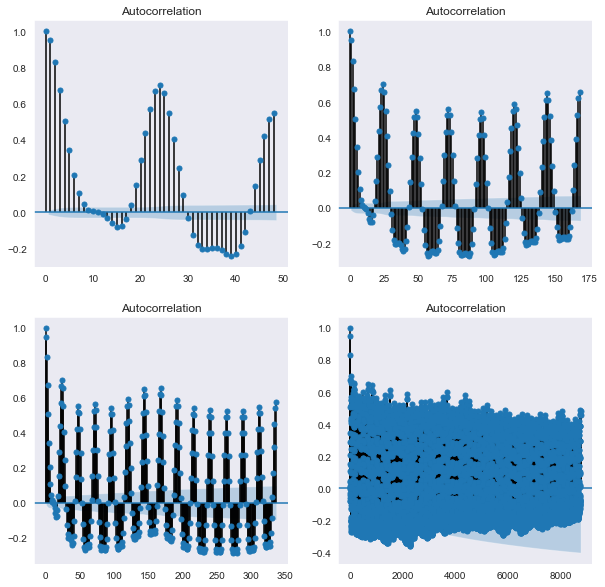

In [65]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [48, 24*7, 24*14, 24*365]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train_flat, lags=lag, ax=ax)
plt.show()

The autocorrelation plot shows significant positive corelations in the first 9 lags. However in this problem we are attempting to forecast the next 24 hours and using a lag less than 24 does not capture the full context of a short-term day ahead forecast.

The cyclic pattern of the autoregressive features is apprent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 4000 lags (approximately 1/2 year).

For the scope of this project calculating with 4000 lags is not feasible. We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).

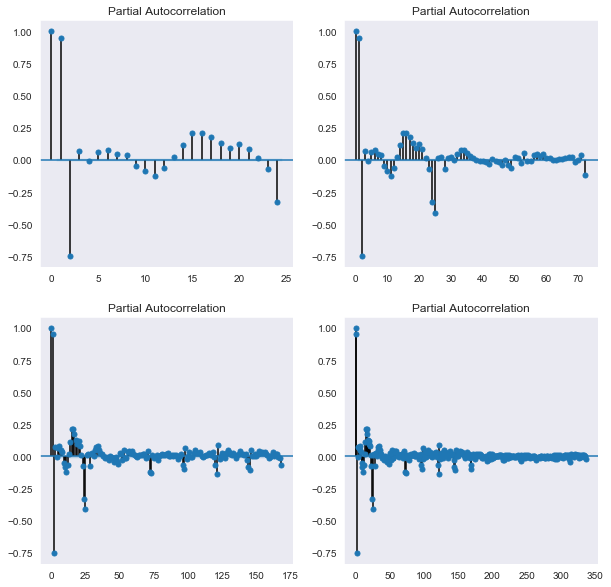

In [68]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train_flat, lags=lag, ax=ax)
plt.show()

The partial autocorrelation plot shows that beyond 24 lags there is no signficant partial autocorrelation. Considering this we will investigate lags 2, 3, 12, and 24 for the moving average values.

##### Summary of hyperparmeter values to investigate

- p (autoregressive): 24, 48, 168
- d (differncing): 0, 24, 168
- q (moving average): 0, 2, 3, 12, 24

### ARIMA Model 1: Baseline Parameters

Baseline parametres are chosen as (p, d, q) = (24, 0, 0)

In [ ]:
# able to run the arima model inside the test harness
# calcualte errors
# plot errors

# THEN we can mount google cloud VM and go BONKERS

In [78]:
### use lag of 1 as a test


def arima_model(history):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    #initalize the ARIMA model
    model = ARIMA(history_flat, order=(1, 0, 0))
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast, _, _ = model_fit.forecast(24)
    
    #save the model
    #name = 'model-' + str(datetime.datetime.now()) +'.pkl'
    #model_fit.save(name)
    
    #print('Done. Model Saved.')
    
    return forecast

In [69]:
#### save aRIMA bug workaround
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

In [73]:
str(datetime.datetime.now())

'2019-09-03 12:40:59.224082'

In [79]:
errors, errors_mean = walk_forward_evaluation(arima_model, train, test, 'arima_model')

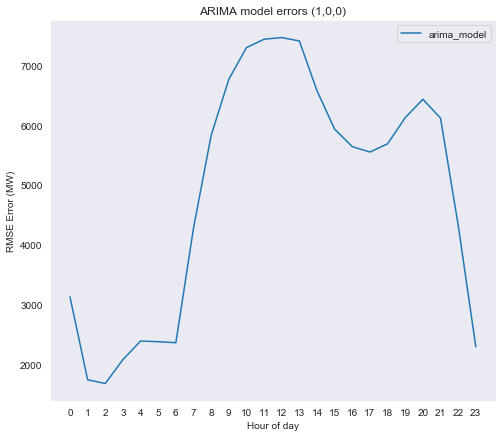

In [81]:
plot_error(errors, result_set=['arima_model'], title='ARIMA model errors (1,0,0)')

In [28]:
### reshape the data (flatten) for input into ARIMA
print(train.shape)
train.values[:2]

(1096, 24)


array([[25385., 24382., 22734., 21286., 20264., 19905., 20010., 20377.,
        20094., 20637., 22250., 23547., 24133., 24713., 24672., 23528.,
        23118., 23606., 26447., 28020., 29014., 29571., 29031., 26798.],
       [27070., 24935., 23214., 22540., 22096., 22066., 22275., 23025.,
        23699., 25834., 27927., 29072., 29071., 29439., 29241., 27973.,
        27320., 27157., 29045., 31967., 33266., 33668., 32426., 29705.]])

In [5]:
#### save aRIMA bug workaround

def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

In [6]:
ARIMA.__getnewargs__ = __getnewargs__

In [8]:
#because of the shape of the data we can flatten directly and input into the model
#


train = train.values.flatten()

In [9]:
### differencing by 24 periods
### forecast 24 periods in advance
model_24 = ARIMA(train, order=(24, 0, 0))
    
model_fit_24 = model_24.fit()
    
    
forecast_24, std_24, intervals_24 = model_fit_24.forecast(24)
print('done_')
model_fit_24.save('model_fit_24.pkl')
print('saved')

done_
saved


In [10]:
### differencing by 24 periods
### forecast 24 periods in advance
model_7 = ARIMA(train, order=(7, 0, 0))
    
model_fit_7 = model_7.fit()
    
    
forecast_7, std_7, intervals_7 = model_fit_7.forecast(24)
print('done_')
model_fit_7.save('model_fit_7.pkl')
print('saved')

done_
saved


In [58]:
### differencing by 1 periods
### forecast 1 periods in advance
model_1 = ARIMA(train_flat, order=(0, 0, 0))
    
model_fit_1 = model_1.fit()
    
    
forecast_1, std_1, intervals_1 = model_fit_1.forecast(24)
print('done_')
model_fit_1.save('model_fit_0.pkl')
print('saved')

done_
saved


In [ ]:
### differencing by 365 periods
### forecast 365 periods in advance
model_365 = ARIMA(train, order=(365, 0, 0))
    
model_fit_365 = model_365.fit()
    
    
forecast_365, std_365, intervals_365 = model_fit_365.forecast(24)
print('done_')
model_fit_365.save('model_fit_365.pkl')
print('saved')

In [16]:
loaded_1 = ARIMAResults.load('model_fit_1.pkl')
forecast_1, std_1, intervals_1=loaded_1.forecast(24)

loaded_7 = ARIMAResults.load('model_fit_7.pkl')
forecast_7, std_7, intervals_7=loaded_7.forecast(24)

loaded_24 = ARIMAResults.load('model_fit_24.pkl')
forecast_24, std_24, intervals_24=loaded_24.forecast(24)

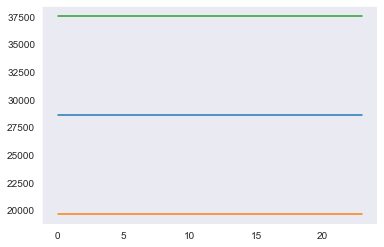

In [59]:
plt.plot(forecast_1)
plt.plot(intervals_1[:,0])
plt.plot(intervals_1[:,1])

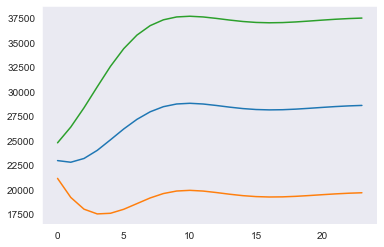

In [18]:
plt.plot(forecast_7)
plt.plot(intervals_7[:,0])
plt.plot(intervals_7[:,1])

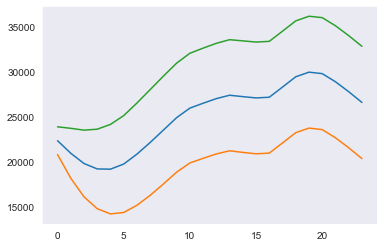

In [19]:
plt.plot(forecast_24)
plt.plot(intervals_24[:,0])
plt.plot(intervals_24[:,1])

In [15]:
forecast_24.shape

(24,)

In [23]:
test.columns

Index(['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23'],
      dtype='object')

In [26]:
forecast = pd.DataFrame(np.reshape(forecast_24, (1,-1)), columns=test.columns)
forecast

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
0,22355.53582,20962.763593,19829.892661,19227.496465,19202.241934,19767.964063,20865.569643,22158.161672,23532.17009,24908.289419,...,27235.603078,27091.17696,27167.572515,28292.861388,29432.371443,29943.980444,29783.315049,28883.132865,27784.432031,26591.689976


In [30]:
test.iloc[0,:]

t-0 h_0     22779.0
t-0 h_1     22009.0
t-0 h_2     20589.0
t-0 h_3     19547.0
t-0 h_4     18871.0
t-0 h_5     18688.0
t-0 h_6     18869.0
t-0 h_7     19263.0
t-0 h_8     19046.0
t-0 h_9     19563.0
t-0 h_10    21063.0
t-0 h_11    22448.0
t-0 h_12    23033.0
t-0 h_13    23680.0
t-0 h_14    23918.0
t-0 h_15    22626.0
t-0 h_16    22130.0
t-0 h_17    22607.0
t-0 h_18    25198.0
t-0 h_19    26477.0
t-0 h_20    27326.0
t-0 h_21    27534.0
t-0 h_22    26946.0
t-0 h_23    24878.0
Name: 2018-01-01 00:00:00, dtype: float64

In [27]:
#predictions = pd.DataFrame(forecast_24, index = test.index, columns = test.columns)

errors, error_mean = calculate_errors(forecast, test.iloc[0,:], 'forecast_24')


IndexingError: Too many indexers